Feature Engineering tamamlandı. X shape: (30000, 50)
Accuracy: 0.9228
              precision    recall  f1-score   support

   Cancelled       0.37      0.14      0.20       422
   Completed       1.00      1.00      1.00      4297
      Missed       0.76      0.92      0.84      1281

    accuracy                           0.92      6000
   macro avg       0.71      0.69      0.68      6000
weighted avg       0.91      0.92      0.91      6000



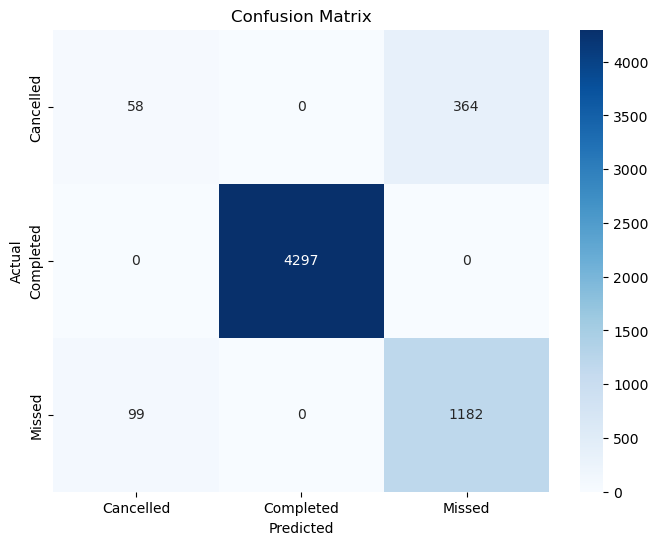

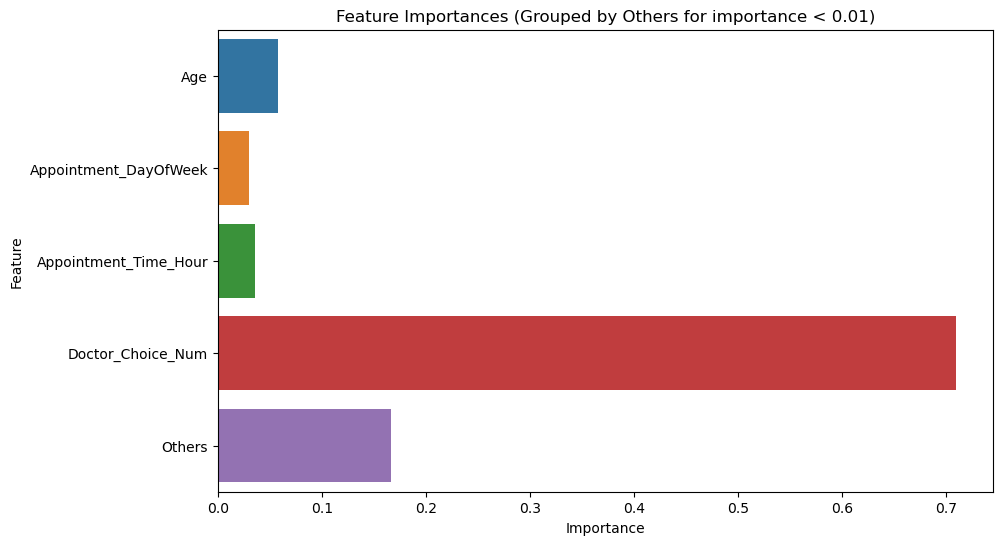

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns

# 1. VERİLERİ OKU
patients = pd.read_csv("patients.csv")
doctors = pd.read_csv("doctors.csv")
appointments = pd.read_csv("appointments.csv")

# 2. VERİLERİ BİRLEŞTİR
df = appointments.merge(patients, on="Patient_ID", how="left")
df = df.merge(doctors[["Doctor_ID", "Specialty"]], on="Doctor_ID", how="left")

# 3. ZAMAN FEATURE'LARI
df['Date'] = pd.to_datetime(df['Date'])
df['Appointment_DayOfWeek'] = df['Date'].dt.dayofweek  # Pazartesi=0
df['Is_Weekend'] = df['Appointment_DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)

df['Appointment_Time_Hour'] = df['Time'].apply(lambda x: int(x.split(":")[0]))
df['Is_Morning'] = df['Appointment_Time_Hour'].apply(lambda x: 1 if x < 12 else 0)

# 4. YAŞ GRUBU
def age_group(age):
    if age < 18:
        return 'Child'
    elif age < 65:
        return 'Adult'
    else:
        return 'Senior'
df['Age_Group'] = df['Age'].apply(age_group)

# 5. KRONİK HASTALIK
df['Has_Chronic_Disease'] = df['Chronic_Disease'].apply(lambda x: 0 if x == "None" else 1)

# 6. HASTANE → ŞEHİR HARİTASI
hospital_city_map = {
    "Koç Üniversitesi Hastanesi": "İstanbul",
    "Haseki Eğitim ve Araştırma Hastanesi": "İstanbul",
    "Şişli Hamidiye Etfal Eğitim ve Araştırma Hastanesi": "İstanbul",
    "Bakırköy Dr. Sadi Konuk Eğitim ve Araştırma Hastanesi": "İstanbul",
    "Özel City Hospital": "Ankara",
    "Ankara Bilkent Şehir Hastanesi": "Ankara",
    "GATA Haydarpaşa Eğitim ve Araştırma Hastanesi": "Ankara",
    "Dışkapı Yıldırım Beyazıt Eğitim ve Araştırma Hastanesi": "Ankara",
    "Özel Ege Şehir Hastanesi": "İzmir",
    "İzmir Atatürk Eğitim ve Araştırma Hastanesi": "İzmir",
    "İzmir Bozyaka Eğitim ve Araştırma Hastanesi": "İzmir",
    "İzmir Tepecik Eğitim ve Araştırma Hastanesi": "İzmir",
    "Özel Acıbadem Bursa Hastanesi": "Bursa",
    "Bursa Şehir Hastanesi": "Bursa",
    "Bursa Çekirge Devlet Hastanesi": "Bursa",
    "Bursa Yüksek İhtisas Eğitim ve Araştırma Hastanesi": "Bursa"
}
df['City'] = df['Hospital'].map(hospital_city_map)

# 7. ÖZELLİKLERİ BELİRLE
feature_cols = [
    'Age', 'Gender', 'Chronic_Disease', 'Specialty', 'Hospital', 'City',
    'Appointment_DayOfWeek', 'Is_Weekend', 'Appointment_Time_Hour', 'Is_Morning',
    'Age_Group', 'Has_Chronic_Disease', 'Doctor_Choice_Num'
]

X = df[feature_cols]
y = df['Status']

# 8. ONE-HOT ENCODING
X = pd.get_dummies(X, columns=['Gender', 'Chronic_Disease', 'Specialty', 'Hospital', 'City', 'Age_Group'])

print("Feature Engineering tamamlandı. X shape:", X.shape)

y = appointments['Status']

# Veriyi train-test böl
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Model eğit
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Tahmin yap
y_pred = model.predict(X_test)

# Accuracy hesapla
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# Sonuçları göster
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)

# Confusion matrix üzerinde 0, 1, 2 olan sınıfların anlamlı string karşılıklarını ekleyelim
class_labels = ['Cancelled', 'Completed', 'Missed']

# Heatmap üzerinde sınıf etiketleri göster
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Özelliklerin önem derecelerini göster
feature_importances = model.feature_importances_
features = X.columns

# 0.02'den düşük özelliklerin önem derecelerini "OTHERS" olarak birleştir
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importances
})

# Filtreleme işlemi
importance_df['Feature'] = importance_df.apply(
    lambda row: row['Feature'] if row['Importance'] > 0.01 else 'Others', axis=1
)

# "OTHERS" kısmını gruplama
importance_df = importance_df.groupby('Feature').sum().reset_index()

# Özellikleri bar chart olarak görselleştir
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importances (Grouped by Others for importance < 0.01)")
plt.show()
print("30000 randevunun %20'si test için kalan %80'i eğitim için kullanılmıştır.")